# Exemple 4 - Determination of best reproductive phenological phase length for maize yield, based on 2020-2022

The purpose of this notebook is to determine what would be the length of reproductive phenological phase that leads to the highest yield. This can be of interest for plant breeders, when working about phenological phasing and more globally cycle length of crops.

## Imports

In [8]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import xarray as xr
from sarra_py import *
import geopandas as gpd
from joblib import Parallel, delayed
from contextlib import redirect_stdout, redirect_stderr
import shutil

## 2. Preparing climate and rainfall data, and crop parameters files

For this example, we provide rainfall and climate data for north Cameroon in 2020-2022, sourced from CHIRPS v2.0 for rainfall, and AgERA5 for climate ; the following cell will download it and unzip it. 

- climate data includes daily min, max, mean temperatures (°C), solar irradiance (W/m2), and reference evapotranspiration (mm), sourced from AgERA5
- rainfall data includes... rainfall data (mm), sourced from CHIRPS v2.0



In [3]:
import os
import urllib.request
import zipfile

# create a folder to store the data
os.makedirs('../data/exemple_data/exemple_4/', exist_ok=True)

# download preformatted data from Zenodo repository
url = 'https://zenodo.org/records/11092880/files/SARRA-Py_north_cameroon_2020_2022_example_data.zip?download=1'
local_filename = '../data/exemple_data/exemple_4/SARRA-Py_north_cameroon_2020_2022_example_data.zip' # store the downloaded file in the ../data/exemple_data/ folder
urllib.request.urlretrieve(url, local_filename)
print("File downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_4/SARRA-Py_north_cameroon_2020_2022_example_data.zip"
directory_to_extract_to = "../data/exemple_data/exemple_4/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File unzipped.")

File downloaded using urllib.
File unzipped.


We set the paths to the data :

In [2]:
rainfall_data_path = "../data/exemple_data/exemple_4/CHIRPS_v2.0_Africa_north_cameroon/"
climate_data_path = "../data/exemple_data/exemple_4/AgERA5_north_cameroon/"

And we copy the crop parameters from the example folder to the appropriate locations :

In [3]:
# we copy maize_cameroon_2020. yaml from the example folder to the ../data/params/itk/ folder 
shutil.copy("../data/exemple_data/exemple_4/itk_exemple_4.yaml", "../data/params/itk/itk_exemple_4.yaml")

# we copy maize_north_cameroon.yaml from the example folder to the ../data/params/variete/ folder
shutil.copy("../data/exemple_data/exemple_4/variety_exemple_4.yaml", "../data/params/variety/variety_exemple_4.yaml")

'../data/params/variety/variety_exemple_4.yaml'

## 3. Defining yearly simulation function

Here we define a wrapper function that will perform for a given year all the operations for data loading and launching one simulation per SDJRPR to be tested. 

In [4]:
def find_best_SDJRPR_length(year, SDJRPR_min, SDJRPR_max, interval):

    # to be able to parallelize we first define a function that will run the simulation for a given SDJRPR value
    # it is defined inside the main function so that it has access to all the necessary variables
    def run_simulation(SDJRPR):
        
        print("-> estimating yield for SDJRPR = {} degree days".format(SDJRPR))

        data = base_data.copy() # creating simulation dataset by copying the base_data
        paramITK["DateSemis"] = datetime.date(year, 5, 1) # setting the sowing date (this overrides the sowing date in the itk file)
        paramVariete["SDJRPR"] = SDJRPR # setting the thermal time to flowering (this overrides the value in the variety file)

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

        data = run_model(paramVariete, paramITK, paramTypeSol, data, duration) # running the model
        result = xr.where(data["numPhase"][-1,:,:] != 0, data["rdt"][-1,:,:], np.nan) # extracting the yield, excluding pixels where simulation never started (numPhase = 0)

        del data # free memory
        return result
    
    print("== computing best SDJRPR for year {} ==".format(year))

    # hiding all the outputs of this code section
    with open(os.devnull, 'w') as devnull, redirect_stdout(devnull), redirect_stderr(devnull):

        # defining the simulation period (interval in which data is loaded)
        # remember that we want to load data at least one month before the sowing date so that water balance can initialize properly
        date_start = datetime.date(year,4,1) # 01/04/year
        duration = 365 - datetime.date(year,4,1).timetuple().tm_yday # we define the duration of the simulation as the number of days remaining in the year

        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration) # get grid size 
        base_data = xr.Dataset() # initialize empty xarray dataset
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration) # load rainfall data
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration) # load climate data
        base_data = load_iSDA_soil_data(base_data, grid_width, grid_height) # load soil parameters
        base_data = calc_day_length_raster_fast(base_data, date_start, duration) # compute day length raster

        # load variety, cropping system and soil parameters
        file_paramVariete = "variety_exemple_4.yaml"
        file_paramITK = "itk_exemple_4.yaml"
        file_paramTypeSol = "USA_iowa_V42.yaml"
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

    # parallel run the simulations for the different SDJRPR values to test
    # the function includes arguments defining the SDJRPR min and max, as well as the interval between each tested value
    parallel_jobs = 4 # if you have lots of RAM increase the number of parallel jobs
    results = Parallel(n_jobs=parallel_jobs)(delayed(run_simulation)(value) for value in np.arange(SDJRPR_min, SDJRPR_max, interval)) # parallel run the simulations
    rdt = xr.concat(results, dim="step") # assemble the yield results from all the different SDJRPR values tested in a single xarray dataset

    # find the best SDJRPR value (returning the highest yield) for each pixel with argmax
    # however as argmax is sensitive to NaN values we need to handle them
    all_nan_slices = rdt.isnull().all(dim="step") # identify slices where all values are NaN
    argmax_result = rdt.fillna(np.inf).argmax(dim="step") # compute argmax, ignoring slices with all NaN
    argmax_result = argmax_result.where(~all_nan_slices, np.nan) # Replace indices with NaN where all values were NaN

    return argmax_result

## 4. Run simulations

In [ ]:
# initialize best sowing date array
best_SDJRPR = xr.DataArray()

# loop over the years 2020 to 2022 included
for year in range(2020, 2022 + 1):

    # define best SDJRPR search parameters
    # here we will search for the best SDJRPR value between 360 and 630 degree days, with a 30 degree days interval
    SDJRPR_min, SDJRPR_max = 360, 630
    interval = 30
    argmax_result = find_best_SDJRPR_length(year, SDJRPR_min, SDJRPR_max, interval) # run simulations
    
    # store results, taking care of the first iteration
    if best_SDJRPR.size == 0:
        best_SDJRPR = argmax_result.expand_dims("year")
    else:
        best_SDJRPR = xr.concat([best_SDJRPR, argmax_result], dim="year")

## 5. Plot results

Now that we have the determined the best phase length in degree days for SDJRPR for each year on the period 2020-2022, we can compute temporal agregates to determine the average best SDJRPR value.

Skipping field centroid: unsupported OGR type: 3


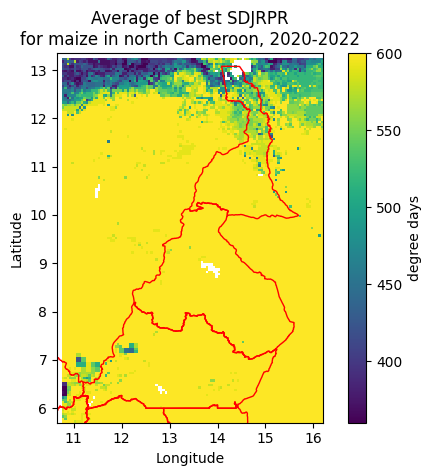

In [12]:
# converting results to DOY
best_SDJRPR_DOY = best_SDJRPR.mean(dim="year") * interval + SDJRPR_min

# plot the results
best_SDJRPR_DOY.plot(cbar_kwargs={"label": "degree days"})
gdf = gpd.read_file("https://fdw.fews.net/api/feature/?layer=1704&format=geojson")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("Average of best SDJRPR\nfor maize in north Cameroon, 2020-2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


On this map, we can see that most of the north Cameroon maize produces its highest yields when reproductive phase length is long ; however the further north we go, especially in the "horn" the shortest this period has to be in order for crops to reach their maximum attainable yield.